# Лабораторная работа №4

ФИО: Поляховская Ольга Александровна
Группа: БИВТ-22-СП-2


Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/1k2MYXEp_OVQrink_XRC1PwoM0ZuNMeNz4VTWY7cI3hE/edit?usp=sharing) необходимо узнать название своего датасета 
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1Phm-Fq1GL-VX7NS-DCEMRh_Fo1wU7DQ9?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` (как мы это делали на семинаре), а затем засунуть в `Dataloader` (тоже делали на семинаре).
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD` ([link](https://pytorch.org/docs/stable/optim.html)).
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy
     2. Для задачи регрессии -- MAE
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

## 1. Пример импорта данных. Грузим данные

In [1]:
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('winequality-red.csv', sep=',')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## 2. Понимаем, какая перед нами задача

Перед нами задача регрессии на прогнозирование оценки красного вина на основе множества парметров его химического состава и вкусовых ощущений.

## 3. Делаем предобработку данных

Проверка пропусков в датасете

In [2]:
print(f'Пропуски в колонках датасета:\n{data.isnull().sum()}')

Пропуски в колонках датасета:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Разделение выборки на тренировочную и тестовую

In [3]:
from sklearn.model_selection import train_test_split

x = data.drop(columns=['quality'])
y = pd.DataFrame(data['quality'].values)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

print(f'Тренировочная выборка x:\n{x_train}\n')
print(f'Тренировочная выборка y:\n {y_train}\n')
print(f'Тестовая выборка x:\n {x_test}\n')
print(f'Тестовая выборка y:\n {y_test}\n')

Тренировочная выборка x:
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
781             6.5             0.460         0.14             2.4      0.114   
308            10.3             0.430         0.44             2.4      0.214   
323            10.3             0.590         0.42             2.8      0.090   
364            12.8             0.615         0.66             5.8      0.083   
1138            7.5             0.410         0.15             3.7      0.104   
...             ...               ...          ...             ...        ...   
1572            7.3             0.690         0.32             2.2      0.069   
256             9.4             0.340         0.37             2.2      0.075   
1289            7.0             0.600         0.30             4.5      0.068   
540             9.2             0.590         0.24             3.3      0.101   
1364            7.2             0.605         0.02             1.9      0.096   

  

Нормирование численных переменных

In [4]:
for elem in x.keys():
	x_test[elem] = MinMaxScaler().fit_transform(x_test[elem].values.reshape(-1, 1))
	x_train[elem] = MinMaxScaler().fit_transform(x_train[elem].values.reshape(-1, 1))

for elem in y.keys():
	y_test[elem] = MinMaxScaler().fit_transform(y_test[elem].values.reshape(-1, 1))
	y_train[elem] = MinMaxScaler().fit_transform(y_train[elem].values.reshape(-1, 1))
print(x_test, x_train, y_test, y_train)


      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
735        0.254717          0.566901         0.10        0.063380   0.124561   
496        0.264151          0.253521         0.25        0.049296   0.070175   
1582       0.103774          0.390845         0.10        0.098592   0.021053   
870        0.254717          0.390845         0.01        0.063380   0.040351   
1115       0.188679          0.373239         0.07        0.091549   0.087719   
...             ...               ...          ...             ...        ...   
1567       0.207547          0.376761         0.13        0.056338   0.061404   
143        0.122642          0.161972         0.08        0.035211   0.043860   
806        0.320755          0.063380         0.39        0.056338   0.000000   
1593       0.169811          0.323944         0.08        0.049296   0.047368   
1542       0.160377          0.489437         0.02        0.049296   0.040351   

      free sulfur dioxide  

In [5]:
print(type(y), type(x))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


## 4. Оформляем данные в виде класса Dataset и создаем DataLoader

Создадим класс MyDataset, который наследуется от абстрактного класса Dataset и берет данные (признаки и целевую переменную) для  преобразования их в тензоры.

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.values, dtype=torch.float32) 
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

Создаем DataLoader

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## 5. Обучение на тренировочном множестве
Простая однослойная нейросеть с оптимизатором SGD

In [8]:
import torch.nn as nn
import torch.optim as optim

class SingleLayer(nn.Module):
    def __init__(self, input_dim):
        super(SingleLayer, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

input_dim = x_train.shape[1]
model1 = SingleLayer(input_dim)

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model1.parameters(), lr=0.01)

num_epochs = 200
train_losses = []
test_losses = []


for epoch in range(num_epochs):
    model1.train() 
    
    batch_train_loss = 0.0
    
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad() 
        
        y_pred = model1(x_batch.float()).squeeze()  
        
        loss = loss_fn(y_pred, y_batch.float())
        batch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_losses.append(batch_train_loss / len(train_loader))
    
    model1.eval()
    with torch.no_grad():
        batch_test_loss = 0.0
        for x_batch, y_batch in test_loader:
            y_pred = model1(x_batch.float()).squeeze()
            loss = loss_fn(y_pred, y_batch.float())
            batch_test_loss += loss.item()
        test_losses.append(batch_test_loss / len(test_loader))

c:\Users\Polyak\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Polyak\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Polyak\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to in

Рисуем кривую обучения модели 

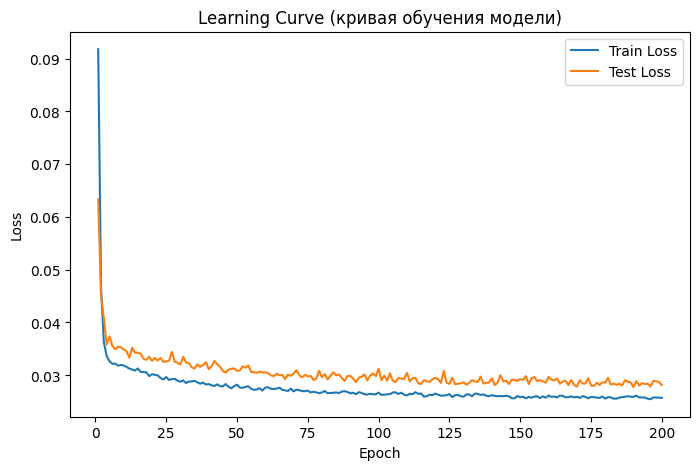

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (кривая обучения модели)')
plt.legend()
plt.show()

Подсчитать метрики на train и test множествах

In [17]:
from sklearn.metrics import mean_absolute_error

def compute_mae(model, data_loader):
    model.eval()  
    
    all_preds = []
    all_labels = []
    with torch.no_grad():  
        for x_batch, y_batch in data_loader:
            y_pred = model(x_batch.float()).squeeze()  
            y_batch = y_batch  
            
            all_preds.extend(y_pred.cpu().numpy())  
            all_labels.extend(y_batch.cpu().numpy())
    
    return mean_absolute_error(all_labels, all_preds)  

train_mae = compute_mae(model1, train_loader)
test_mae = compute_mae(model1, test_loader)

print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Train MAE: 0.1372
Test MAE: 0.1420


5.2 Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором Adam


In [11]:
class SingleHiddenLayerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SingleHiddenLayerModel, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim) 
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x


input_dim = x_train.shape[1]
hidden_dim = 64 

model2 = SingleHiddenLayerModel(input_dim, hidden_dim)
loss_fn = nn.MSELoss() 
optimizer = optim.Adam(model2.parameters(), lr=0.01)

num_epochs = 700

train_losses = []
test_losses = []


for epoch in range(num_epochs):
    model2.train()  

    batch_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad() 
        y_pred = model2(x_batch.float()).squeeze()

        loss = loss_fn(y_pred, y_batch.float())
        batch_train_loss += loss.item()

        loss.backward()
        optimizer.step()  

    train_losses.append(batch_train_loss / len(train_loader)) 

    model2.eval() 
    with torch.no_grad():
        batch_test_loss = 0.0
        for x_batch, y_batch in test_loader:
            y_pred = model2(x_batch.float()).squeeze()
            loss = loss_fn(y_pred, y_batch.float())
            batch_test_loss += loss.item()
        test_losses.append(batch_test_loss / len(test_loader)) 

c:\Users\Polyak\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Polyak\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Polyak\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to in

Рисуем кривую обучения модели 

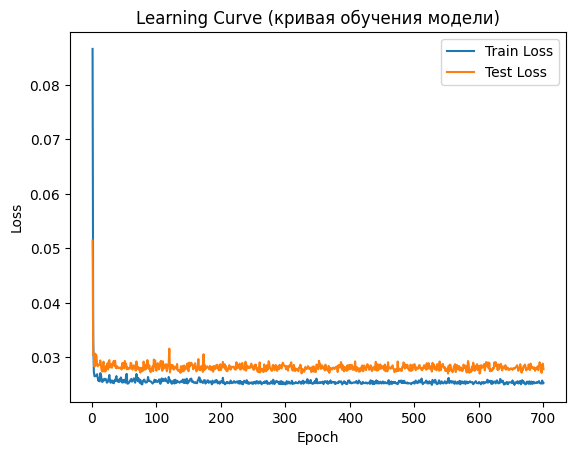

In [12]:
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (кривая обучения модели)')
plt.legend()
plt.show()

Подсчитать метрики на train и test множествах

In [19]:
from sklearn.metrics import mean_absolute_error
  
train_mae = compute_mae(model2, train_loader)
test_mae = compute_mae(model2, test_loader)

print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Train MAE: 0.1351
Test MAE: 0.1385


5.3 Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором Adam

In [14]:
class ThirdLayerNN(nn.Module):
    def __init__(self, input_dim):
        super(ThirdLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64) 
        self.fc2 = nn.Linear(64, 64)   
        self.fc3 = nn.Linear(64, 32) 
        self.fc4 = nn.Linear(32, 1) 

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

input_dim = x_train.shape[1]
model3 = ThirdLayerNN(input_dim)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(model3.parameters(), lr=0.001)

num_epochs = 300
train_losses = []
test_losses = []


for epoch in range(num_epochs):
    model3.train()  
    
    batch_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        y_pred = model3(x_batch.float()).squeeze()
        
        loss = loss_fn(y_pred, y_batch.float()) 
        batch_train_loss += loss.item() 
        loss.backward() 
        optimizer.step()

    train_losses.append(batch_train_loss / len(train_loader))
    
    model3.eval() 
    with torch.no_grad(): 
        batch_test_loss = 0.0
        for x_batch, y_batch in test_loader:
            y_pred = model3(x_batch.float()).squeeze()
            loss = loss_fn(y_pred, y_batch.float())
            batch_test_loss += loss.item()
        test_losses.append(batch_test_loss / len(test_loader))
    

c:\Users\Polyak\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Polyak\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Polyak\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to in

Рисуем кривую обучения модели

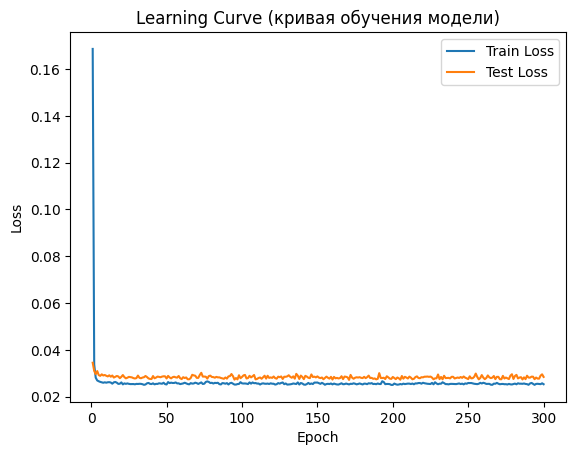

In [15]:
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (кривая обучения модели)')
plt.legend()
plt.show()

Подсчитать метрики на train и test множествах

In [20]:
from sklearn.metrics import mean_absolute_error 

train_mae = compute_mae(model3, train_loader)
test_mae = compute_mae(model3, test_loader)

print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Train MAE: 0.1345
Test MAE: 0.1381


## 6. Сравнение метрик

Модель 1 (нейросеть c 1 слоем, оптимизатор SGD) показывает наименьшие значения MAE как для тренировочного, так и для тестового множества. Это означает, что она справилась лучше всего с поставленной задачей  

На основе полученных метрик переобучение не наблюдается для всех моделей.  
Переобучение происходит, когда модель слишком хорошо подгоняет данные на тренировочном множестве, но плохо работает на тестовом. Это можно заметить по резкому падению MAE на тренировочном множестве и значительному ухудшению на тестовом.   

Недообучение происходит, когда модель не способна достаточно хорошо подогнать данные на тренировочном множестве, что проявляется в высоких значениях MAE как на тренировочном, так и на тестовом множестве.
Все модели в среднем показывают одинаково невысокие значения, значит недообучения не наблюдается